# 对话聚类

## 1. 数据清洗
- 将每段对话合并为一行
- 正则表达式替换特定字符串
- 分词
- 删除停用词（包括长度为1的词）

In [53]:
import re
import jieba
import logging
import time

raw_file = 'chat-short-20w.txt'
stop_wrods_file = 'stop_words.txt'

jieba.setLogLevel(logging.INFO)
logging.basicConfig(format='%(message)s', level=logging.DEBUG)

def substitute(sent):
    exps = [
        r'#E-\w\[数字x\]|~O\(∩_∩\)O/~',
        r'http[s]?://[a-zA-Z0-9|\.|/]+',
        r'http[s]?://[a-zA-Z0-9\./-]*\[链接x\]',
        r'\[ORDERID_[0-9]+\]',
        r'\[日期x\]',
        r'\[时间x\]',
        r'\[金额x\]',
        r'\[站点x\]',
        r'\[数字x\]',
        r'\[地址x\]',
        r'\[姓名x\]',
        r'\[邮箱x\]',
        r'\[电话x\]',
        r'\[商品快照\]',
        r'<s>',
        r'\s+',
        r'[a-z|0-9]+'
        "[\s+\.\!\/_,$%^:*(+\"\')]+",
        "[+——()?:【】‘’“”`！，。？、~@#￥%……&*（）]+"
    ]
    for exp in exps:
        sent = re.sub(exp, ' ', sent)
    return sent

logging.info('数据清洗开始...')

# 读取原始数据文件
with open(raw_file, encoding='utf-8') as f:
    data = f.read().strip().split('\n\n')  # '\n\n'分隔每段对话
    
# 将每段对话合并为一行
corpus = []
for conv_raw in data:
    conv = conv_raw.strip().split('\n')  # '\n'分隔每句话
    conv = list(map(lambda x: x.strip()[2:], conv))  # 去除开头的0/1标记
    corpus.append(' '.join(conv))    
logging.info('Step1: 合并完成 (共%d段对话)' % len(corpus))


# 正则表达式替换特定字符串
corpus = list(map(substitute, corpus))
logging.info('Setp2: 正则表达式替换完成')

# 分词
t = time.time()
corpus = list(map(jieba.cut, corpus))
logging.info('Step3: 分词完成')

# 删除停用词
logging.info('Step4: 删除停用词开始...')
with open(stop_wrods_file, encoding='utf-8') as f:
    stop_words = f.read().strip().split('\n')
    
t = time.time()
for i in range(len(corpus)):
    tokens = []
    for token in corpus[i]:
        token = token.strip()
        if len(token) > 1 and token not in stop_words:
            tokens.append(token)
    corpus[i] = tokens
logging.info('Step4: 删除停用词完成 (用时: %.2fs)' % (time.time() - t))

# 组合
corpus = list(map(lambda x: ' '.join(x), corpus))

logging.info('数据清洗完成.')

数据清洗开始...
Step1: 合并完成 (共10942段对话)
Setp2: 正则表达式替换完成
Step3: 分词完成
Step4: 删除停用词开始...
Step4: 删除停用词完成 (用时: 21.08s)
数据清洗完成.


## 2. 转化为TFIDF标签

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 关键超参数
max_df=0.1
min_df = 20
max_features=1000

tfidf_vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, max_features=max_features)
tfidf = tfidf_vectorizer.fit_transform(corpus)
logging.info('tfifd标签转化完成')

tfifd标签转化完成


words: 1000

Conv 1: 先发 有货 到货 操作 我家 啥时候 一周 快点 希望 关注 库房 多久 左右 两个 物流 稍等一下 建议您



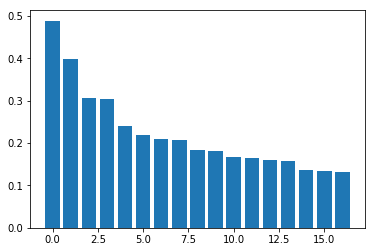

Conv 2: 耽误 及时 着急 拦截 签收 下发 我点 过程 能查 第一次 灰常 这次 这种 估计 算了 积极 这么久 为止 直到 包裹 两天 就行 恢复 添麻烦 真的 谅解 明白 荣幸 关注 帮忙



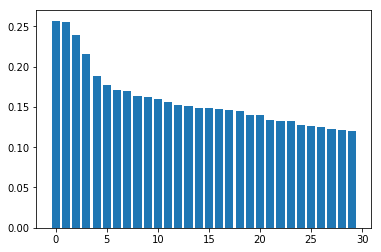

Conv 3: 信用卡 银行 银行卡 周期 工作日 剩余 普通 实际 原路 为准 储蓄卡 退回 支付 返回 看看



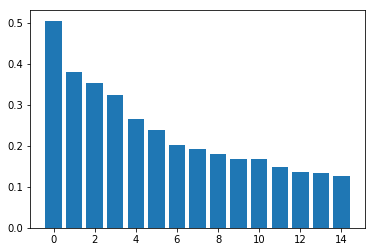

Conv 4: 价保 啥时候 进度 方式 id 请稍等 差价 付款 返回 工作日 稍等一下



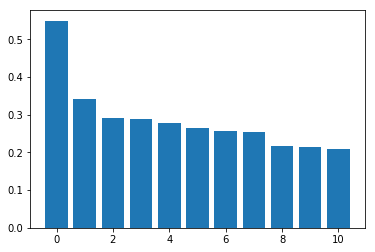

Conv 5: 手表 调整 跳转 亲亲 一块 过程 我先 分钟 上次 正确 日期 编号 晚上 方式 是不是 进行 确认 看看



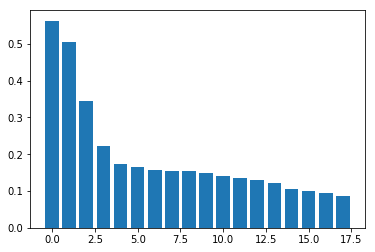

In [82]:
import matplotlib.pyplot as plt

print('words:', len(tfidf_vectorizer.vocabulary_), end='\n\n')

terms = tfidf_vectorizer.get_feature_names()
conv_idx = 0
for row in tfidf[:5]:
    conv_idx += 1
    print('Conv %d: ' % conv_idx, end='')
    row = row.toarray().squeeze()
    num = min(30, (row != 0).sum())
    indexes = row.argsort()[:-1-num:-1]
    words = [terms[idx] for idx in indexes]
    print(' '.join(words), end='\n\n')
    
    values = [row[idx] for idx in indexes]
    plt.bar(range(len(values)), values)
    plt.show()

## 3. Cluster
- Use kmeans

In [84]:
from sklearn.cluster import KMeans

n_clusters=50
max_iter=100

kmeans = KMeans(n_clusters=n_clusters,
                    max_iter=max_iter,
                    n_init=8,
                    init='k-means++',
                    n_jobs=-1,
                    random_state=0,
                    verbose=2)
labels = kmeans.fit_predict(tfidf)

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 15458.489
Iteration  0, inertia 10561.943
Iteration  0, inertia 15622.129
Iteration  0, inertia 15525.568
Iteration  1, inertia 9540.153
Iteration  1, inertia 9166.440
Iteration  1, inertia 9238.047
Iteration  1, inertia 9196.286
Iteration  2, inertia 9177.764
Iteration  2, inertia 9062.136
Iteration  2, inertia 8969.824
Iteration  2, inertia 9003.151
Iteration  3, inertia 9068.336
Iteration  3, inertia 8890.278
Iteration  3, inertia 8975.162
Iteration  3, inertia 8934.301
Iteration  4, inertia 9029.787
Iteration  4, inertia 8858.973
Iteration  4, inertia 8914.343
Iteration  4, inertia 8901.996
Iteration  5, inertia 9010.891
Iteration  5, inertia 8884.835
Iteration  5, inertia 8846.725
Iteration  5, inertia 8881.617
Iteration  6, inertia 8998.658
Iteration  6, inertia 8834.775
Iteration  6, inertia 8869.166
Iteration  6, inertia 8869.297
Iteration  7, inertia 8990.148
I

Iteration 11, inertia 9079.168
Iteration 43, inertia 8965.246
Iteration 38, inertia 9000.015
Iteration 12, inertia 9078.807
Iteration 44, inertia 8965.073
Iteration 39, inertia 8999.977
Iteration 13, inertia 9078.303
Iteration 45, inertia 8965.006
Iteration 40, inertia 8999.962
Iteration 14, inertia 9077.753
Iteration 46, inertia 8964.980
Iteration 41, inertia 8999.934
Iteration 15, inertia 9077.399
Iteration 47, inertia 8964.956
Iteration 42, inertia 8999.902
Iteration 16, inertia 9076.912
Iteration 48, inertia 8964.939
Iteration 43, inertia 8999.895
Iteration 17, inertia 9076.338
Iteration 49, inertia 8964.917
Iteration 44, inertia 8999.889
Converged at iteration 44: center shift 0.000000e+00 within tolerance 9.743080e-08
Iteration 18, inertia 9075.577
Iteration 50, inertia 8964.890
Iteration 19, inertia 9075.022
Iteration 51, inertia 8964.827
Iteration 20, inertia 9074.533
Iteration 52, inertia 8964.778
Iteration 21, inertia 9074.260
Iteration 53, inertia 8964.764
Iteration 22, iner

## 4. Key words

In [98]:
from sklearn.feature_extraction.text import CountVectorizer

clusters = [[] for _ in range(n_clusters)]
for i in range(len(corpus)):
    clusters[labels[i]].append(corpus[i])

idx = 0
for k in range(20):
    vectorizer = CountVectorizer()
    count = vectorizer.fit_transform(clusters[k])
    words = vectorizer.get_feature_names()
    counts = count.toarray().sum(0)
    index = counts.argsort()[-1:-1-15:-1]

    print('Topic #%d: (%d) ' % (idx, len(clusters[k])), end='')
    idx += 1
    for i in index:
        print(words[i], end=' ')
    print('\n')

Topic #0: (222) 取消 拦截 订单 退款 成功 处理 请问 申请 问题 谢谢 拒收 配送 已经 帮到 下单 

Topic #1: (68) 需要 联系 电脑 谢谢 请问 处理 问题 亲爱 一直 客气 客户 为您服务 乐意 帮到 订单 

Topic #2: (321) 取件 问题 处理 上门 请问 退货 申请 售后 需要 谢谢 解决 帮到 地址 一下 商品 

Topic #3: (40) 售后 申请 gt 处理 问题 订单 打开 京东 确认 退换货 返修 商品 收货 手机 维修 

Topic #4: (58) 工作日 退款 取消 时效 问题 一下 微信 处理 订单 支付 两个 零钱 信用卡 储蓄卡 客户 

Topic #5: (303) 修改 订单 地址 请问 问题 处理 取消 下单 解决 时间 一下 您好 配送 谢谢 帮到 

Topic #6: (251) 请问 再见 问题 京东 支持 订单 帮到 祝您 生活 感谢您 愉快 谢谢 处理 解决 取消 

Topic #7: (133) 申请 价保 订单 问题 请问 处理 成功 谢谢 需要 商品 订单号 解决 帮到 降价 支付 

Topic #8: (233) 安装 请问 问题 订单 处理 需要 服务 电话 预约 解决 一下 谢谢 帮到 售后 厂家 

Topic #9: (97) 退款 亲爱 处理 返还 订单 回复 之后 需要 问题 拒收 取消 一直 完成 咨询 申请 

Topic #10: (245) 问题 客服 处理 请问 订单 谢谢 申请 解决 一下 需要 余额 退款 帮到 麻烦 提供 

Topic #11: (239) 发票 请问 订单 处理 问题 开具 一下 谢谢 商品 解决 需要 您好 帮到 查询 已经 

Topic #12: (230) 物流 问题 处理 请问 订单 配送 信息 解决 更新 谢谢 帮到 京东 时间 发货 今天 

Topic #13: (258) 拒收 退款 处理 订单 问题 请问 取消 商品 申请 已经 谢谢 帮到 解决 退货 需要 

Topic #14: (151) 师傅 处理 配送 联系 问题 电话 请问 站点 订单 解决 地址 帮到 谢谢 一下 快递 

Topic #15: (178) 发票 电子 订单 开具 问题 请问 处理 查询 谢谢 完成

## 5. Conversations

In [99]:
with open('chat-short-20w.txt', encoding='utf8') as f:
    cons = f.read().strip().split('\n\n')

clusters = [[] for _ in range(n_clusters)]
for i in range(len(cons)):
    clusters[labels[i]].append(cons[i])

topic_idx = 9

for conv in clusters[topic_idx][:15]:
    print(conv, end='\n\n')

1 有什么问题我可以帮您处理或解决呢?
0 麻烦别发货了，不想买了
1 好的，请您稍等，这边咨询不是一对一，同时需要回复多个消息，我会尽快回复您。#E-s[数字x] 如果拦截不成功还要麻烦您拒收
0 我好的，谢谢
1 拒收之后一般[数字x]天退回来，收到处理您的退款哈 退款完成之后[数字x]-[数字x]个工作日返还哦，您这边查收。款项都是原路返还的哦，亲爱的 请您放心，小妹会一直帮您跟进至订单删除，财务退款的，亲爱的~~ 请问还有其他还可以帮到您的吗? 您客气啦，亲爱的客户，有什么需要，可以联系我哦，我一直在电脑旁的，很乐意为您服务的哟
0 没有了，谢谢

0 可以执行退款 [时间x]] 可以执行退款
1 有什么问题我可以帮您处理或解决呢? 好的，请您稍等，这边咨询不是一对一，同时需要回复多个消息，我会尽快回复您。#E-s[数字x]
0 可以执行退款
1 退款完成之后[数字x]-[数字x]个工作日返还哦，您这边查收。款项都是原路返还的哦，亲爱的 已经退当中了哈
0 这样啊
1 #E-s[数字x]#E-s[数字x] 请问还有其他还可以帮到您的吗?
0 没啦

0 你好
1 有什么问题我可以帮您处理或解决呢? 亲爱的，妹子在的哦，您看这边有什么可以帮到您的吗#E-s[数字x]
0 我有笔订单拒收了，怎么样申请退款 file:///var/mobile/Containers/Data/Application/[数字x]E-D[数字x]-[数字x]D[数字x]-BFFF-[数字x]C[数字x]B[数字x]C/Documents/CDSCS/html/20[数字x]803[数字x]2_fortoimSDK/[链接x]
1 好的，请您稍等，这边咨询不是一对一，同时需要回复多个消息，我会尽快回复您。#E-s[数字x] 这边给您申请可以吗
0 可以
1 请您稍等一下，正在为您核实处理中哦~ 已经申请了哈 厂家这边签收之后处理退款的 退款完成之后[数字x]-[数字x]个工作日返还哦，您这边查收。款项都是原路返还的哦，亲爱的 请您放心，小妹会一直帮您跟进至订单删除，财务退款的，亲爱的~~
0 我这里查询厂家已经签收了， 需要等多久了?
1 已经为您申请了哈 厂家一个工作日内处理
0 好的
1 请问还有其他还可以帮到您的吗?#E-s[数字x]
0 没有，谢谢

0 我的订单一不小心点了退

In [19]:
import os

cluster_path = './cluster/'

if not os.path.exists(cluster_path):
    os.mkdir(cluster_path)

for i in range(n_clusters):
    file_name = cluster_path + 'cluster-%d.txt' % i
    with open(file_name, 'w', encoding='utf8') as f:
        for conv in clusters[i]:
            f.write(conv + '\n\n')